In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

import gc


In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

NameError: name 'np' is not defined

In [4]:
def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = torch.exp(torch.tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)]))
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.autograd.Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

def ssim(img1, img2, window_size=11, size_average=True):


    # Assuming the image is of shape [N, C, H, W]
    (_, _, channel) = img1.size()

    img1 = img1.unsqueeze(0).permute(0, 3, 1, 2)
    img2 = img2.unsqueeze(0).permute(0, 3, 1, 2)


    # Parameters for SSIM
    C1 = 0.01**2
    C2 = 0.03**2

    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    SSIM_numerator = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))
    SSIM_denominator = ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    SSIM = SSIM_numerator / SSIM_denominator

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

# Combined Loss
def combined_loss(pred, target, lambda_param=0.5):
    l1loss = nn.L1Loss()
    return (1 - lambda_param) * l1loss(pred, target) + lambda_param * d_ssim_loss(pred, target)

In [5]:
LEARNING_RATE = 0.01

N_PRIMARY_SAMPLES = 1000
N_BACKUP_SAMPLES = 0

N_SAMPLES = N_PRIMARY_SAMPLES + N_BACKUP_SAMPLES

IMAGE_SIZE = [256, 256, 3]

In [5]:
# display_var = lambda name, x: print(f"{name}: {x.mean()} {x.std()} {x.min()} {x.max()}")

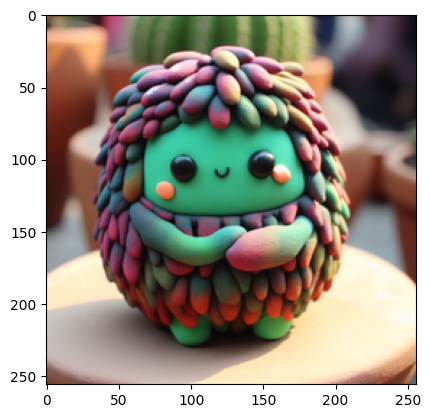

In [6]:
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((IMAGE_SIZE[0],IMAGE_SIZE[1]))
    image = image.convert('RGB')
    image = np.array(image)
    image = image / 255.0
    h, w, c = image.shape
    return image, (h, w, c)

image, shape = load_image('Image-01.png')
plt.imshow(image)

In [7]:
device = torch.device('cuda')
image_tensor = torch.tensor(image, dtype=torch.float32, device=device)
image_tensor.shape

torch.Size([256, 256, 3])

### Get Coordinates in the Image

Load coordinates in the images to be used for testing purposes

In [8]:
coords = np.random.randint(0, [shape[0], shape[1]], size=(N_SAMPLES, 2))
print(coords.min(axis=0))
print(coords.max(axis=0))
# make it a tensor
coords = torch.tensor(coords, device=device)
coords.shape

[0 0]
[255 255]


torch.Size([1000, 2])

In [9]:
random_pixels = image_tensor[coords[:, 0], coords[:, 1]]
random_pixels.shape

torch.Size([1000, 3])

In [10]:
coords_norm = coords / torch.tensor([shape[0]-1, shape[1]-1], device=device).float()
coords_norm = coords_norm * 2 - 1
coords_norm.shape, coords_norm.min(), coords_norm.max()

(torch.Size([1000, 2]),
 tensor(-1., device='cuda:0'),
 tensor(1., device='cuda:0'))

In [11]:
colour_values = image_tensor[coords[:, 0], coords[:, 1]]
# print(colour_values.mean(), colour_values.std(), colour_values.min(), colour_values.max())
# print(colour_values[:3, ...])
# colour_values = torch.logit(colour_values)
# print(colour_values.mean(), colour_values.std(), colour_values.min(), colour_values.max())
colour_values.shape, colour_values[:3, ...]

(torch.Size([1000, 3]),
 tensor([[0.1412, 0.0588, 0.0667],
         [0.3765, 0.1725, 0.1255],
         [0.2235, 0.7725, 0.6196]], device='cuda:0'))

In [12]:
sigma_values = torch.rand(N_SAMPLES, 2, device=device)
rho_values = 2 * torch.rand(N_SAMPLES, 1, device=device) - 1
alpha_values = torch.ones(N_SAMPLES, 1, device=device)*0.8
# display_var('sigma_values', sigma_values)
# display_var('rho_values', rho_values)
# display_var('alpha_values', alpha_values)
print(alpha_values[:10])

tensor([[0.8000],
        [0.8000],
        [0.8000],
        [0.8000],
        [0.8000],
        [0.8000],
        [0.8000],
        [0.8000],
        [0.8000],
        [0.8000]], device='cuda:0')


In [13]:
sigma_values = torch.logit(sigma_values)
rho_values = torch.atanh(rho_values)
alpha_values = torch.atanh(alpha_values)
colour_values = torch.logit(colour_values)
coords_norm = torch.atanh(coords_norm)


W_values = torch.cat([sigma_values, rho_values, alpha_values, colour_values, coords_norm], dim=1)
W_values.shape
sigma_values.shape
print(alpha_values[:10])
print(W_values[:10,3])

tensor([[1.0986],
        [1.0986],
        [1.0986],
        [1.0986],
        [1.0986],
        [1.0986],
        [1.0986],
        [1.0986],
        [1.0986],
        [1.0986]], device='cuda:0')
tensor([1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986,
        1.0986], device='cuda:0')


In [14]:
W = nn.Parameter(W_values)
optimizer = torch.optim.Adam([W], lr=LEARNING_RATE)
loss_history = []
W[:10,3]

tensor([1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986,
        1.0986], device='cuda:0', grad_fn=<SelectBackward0>)

In [15]:
W[:3]

tensor([[ 0.4598, -4.5892,  2.1937,  1.0986, -1.8056, -2.7726, -2.6391, -0.2027,
          0.4283],
        [-0.4121, -3.1701, -0.9554,  1.0986, -0.5046, -1.5677, -1.9414, -0.2860,
         -1.4229],
        [-1.6863, -0.0701,  0.1249,  1.0986, -1.2452,  1.2228,  0.4879, -0.1703,
         -0.4761]], device='cuda:0', grad_fn=<SliceBackward0>)

In [15]:
EPOCHS = 100
densification_interval = 10

In [16]:
def sample_gaussians(gaussian_variables, kernel_size=101):
    # pull the variables
    batch_size = gaussian_variables.shape[0]
    sigma_x = gaussian_variables[:, 0].view(batch_size, 1, 1)
    sigma_y = gaussian_variables[:, 1].view(batch_size, 1, 1)
    rho = gaussian_variables[:, 2].view(batch_size, 1, 1)
    alpha = gaussian_variables[:, 3].view(batch_size, 1)
    colors = gaussian_variables[:, 4:7]
    coords = gaussian_variables[:, 7:9]

    # fix the variables
    sigma_x = F.sigmoid(sigma_x)
    sigma_y = F.sigmoid(sigma_y)
    rho = F.tanh(rho)
    alpha = F.tanh(alpha)
    colors = F.sigmoid(colors)
    coords = F.tanh(coords)
    
    # weight the colors values with alpha
    colors = colors * alpha

    # get covariance
    covariance = torch.stack(
        [torch.stack([sigma_x**2, rho*sigma_x*sigma_y], dim=-1),
        torch.stack([rho*sigma_x*sigma_y, sigma_y**2], dim=-1)],
        dim=-2
    )

    determinant = (sigma_x**2) * (sigma_y**2) - (rho * sigma_x * sigma_y)**2
    if (determinant <= 0).any():
        raise ValueError("Covariance matrix must be positive semi-definite")

    inverse_covariance = torch.inverse(covariance)

    xx = torch.linspace(start=-5, end=5, steps=kernel_size, device=device)
    yy = torch.linspace(start=-5, end=5, steps=kernel_size, device=device)
    xx, yy = torch.meshgrid(xx, yy, indexing='ij')
    xx, yy = xx.unsqueeze(0), yy.unsqueeze(0)
    xy = torch.stack((xx, yy), dim=-1)

    z = torch.einsum('b...i,b...ij,b...j->b...', xy, -0.5 * inverse_covariance, xy)
    kernel = torch.exp(z) / (2 * torch.tensor(np.pi, device=device) * torch.sqrt(torch.det(covariance)).view(batch_size, 1, 1))
    
    kernel_max_1, _ = kernel.max(dim=-1, keepdim=True)  # Find max along the last dimension
    kernel_max_2, _ = kernel_max_1.max(dim=-2, keepdim=True)  # Find max along the second-to-last dimension
    kernel_normalized = kernel / kernel_max_2

    kernel_reshaped = kernel_normalized.repeat(1, 3, 1).view(batch_size * 3, kernel_size, kernel_size)
    kernel_rgb = kernel_reshaped.unsqueeze(0).reshape(batch_size, 3, kernel_size, kernel_size)

    pad_h = shape[0] - kernel_size
    pad_w = shape[1] - kernel_size
    if pad_h < 0 or pad_w < 0:
        raise ValueError("Kernel size should be smaller or equal to the image size.")
    
    padding = (pad_w // 2, pad_w // 2 + pad_w % 2,  # padding left and right
               pad_h // 2, pad_h // 2 + pad_h % 2)  # padding top and bottom
    kernel_rgb_padded = torch.nn.functional.pad(kernel_rgb, padding, "constant", 0)  

    b, c, h, w = kernel_rgb_padded.shape
    theta = torch.zeros(b, 2, 3, dtype=torch.float32, device=device)
    theta[:, 0, 0] = 1.0
    theta[:, 1, 1] = 1.0
    theta[:, :, 2] = coords

    grid = F.affine_grid(theta, size=(b, c, h, w), align_corners=True)
    kernel_rgb_padded_translated = F.grid_sample(kernel_rgb_padded, grid, align_corners=True)

    rgb_values_reshaped = colors.unsqueeze(-1).unsqueeze(-1)

    final_image_layers = rgb_values_reshaped * kernel_rgb_padded_translated
    final_image = final_image_layers.sum(dim=0)
    final_image = torch.clamp(final_image, 0, 1)
    final_image = final_image.permute(1,2,0)

    
    return final_image

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 -> loss 0.024612879380583763


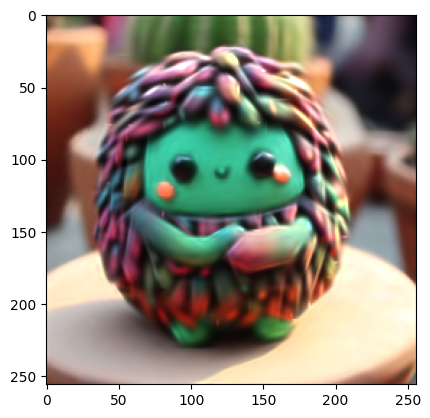

  0%|          | 4/1000 [00:01<07:52,  2.11it/s]


KeyboardInterrupt: 

In [18]:
for epoch in tqdm(range(1000)):

    gaussian_variables = W
    predicted = sample_gaussians(gaussian_variables)
    loss = combined_loss(predicted, image_tensor, lambda_param=0.2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if(epoch % 10 == 0):
        print(f"Epoch {epoch} -> loss {loss.item()}")
        plt.imshow(predicted.detach().to('cpu').numpy())
        plt.show()

In [23]:
params = W.detach().to("cpu").numpy()
params.shape

(1000, 9)

In [20]:
alpha = params[:, 3]
alpha

array([ 1.32845438e+00,  9.39792037e-01,  1.43255606e-01, -8.34020302e-02,
        7.17922747e-01,  1.14954881e-01,  5.44632494e-01,  1.13897908e+00,
        9.98741150e-01,  2.42896155e-02,  2.17465162e-01,  1.34735680e+00,
        6.00887954e-01,  1.61323428e-01,  4.34928745e-01,  5.50129890e-01,
        1.24889171e+00,  1.56306243e+00,  3.33120555e-01,  1.74088478e+00,
        1.54590464e+00,  7.75922775e-01,  5.31147301e-01,  1.56678818e-02,
        8.76034617e-01,  4.78230059e-01,  1.20133996e+00,  6.07155800e-01,
        1.05491304e+00,  1.76981091e+00,  1.81687343e+00,  1.45556879e+00,
        5.57803392e-01,  7.38275766e-01,  1.45760357e+00,  7.08093524e-01,
        1.37222064e+00,  1.32000530e+00,  9.66169357e-01,  1.31935596e+00,
        1.83504820e+00,  1.37692654e+00,  1.14093602e-01,  1.74208140e+00,
        6.13098025e-01,  8.57554078e-01,  9.12269115e-01,  1.30908656e+00,
        1.50076497e+00,  7.32016206e-01,  1.00222433e+00,  1.56741858e-01,
        1.49359179e+00,  

(array([  1.,   1.,   2.,  23., 327., 256., 213., 114.,  54.,   9.]),
 array([-2.70865989, -2.07226539, -1.43587077, -0.79947627, -0.16308169,
         0.47331285,  1.10970736,  1.74610198,  2.3824966 ,  3.0188911 ,
         3.6552856 ]),
 <BarContainer object of 10 artists>)

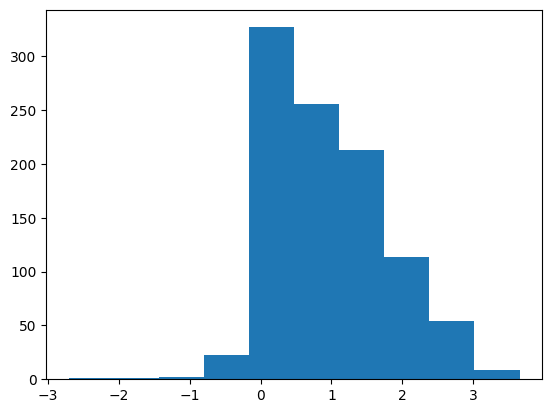

In [24]:
import matplotlib.pyplot as plt

plt.hist(params[:, 3])